<a href="https://colab.research.google.com/github/Ge0f3/tensorflow_certification/blob/main/TF_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)



* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

In [1]:
import numpy as np 
import tensorflow as tf 
import pandas as pd 

# Check for GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9d9fd2ea-d23d-a4a9-d93e-787c05e84215)


## Get Helper Function

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-12 18:38:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-09-12 18:38:18 (16.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data,create_tensorboard_callback,plot_loss_curves,compare_historys

## Download the dateset

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-09-12 18:38:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2022-09-12 18:38:19 (42.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import os 

os.listdir()

['.config',
 'nlp_getting_started.zip',
 'helper_functions.py',
 'train.csv',
 '__pycache__',
 'sample_submission.csv',
 'test.csv',
 'sample_data']

## Read the Data

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
train_df[['text','target']].head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
import seaborn as sns
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
xx = train_df_shuffled['target'].value_counts () .reset_index()


In [11]:
xx

,index,target
0,0,4342
1,1,3271


In [12]:
(4342/7613 ) *100 ,  (3271/7613 ) *100 

(57.03402075397347, 42.96597924602653)

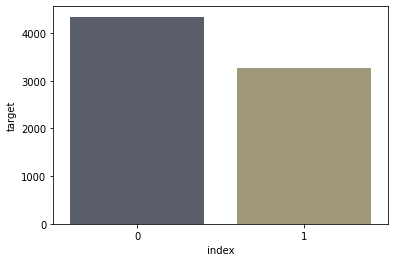

In [13]:
sns.barplot(x='index', y='target', data=xx,palette='cividis')

In [14]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Mini Lalaloopsy Dolls Seed Sunburst June Seashore Sweater Snowstorm Autumn Spice - Full reÛ_ http://t.co/nyty7fCQo6 http://t.co/hyypsPN0yQ

---

Target: 0 (not real disaster)
Text:
My head gonna explode soon

---

Target: 0 (not real disaster)
Text:
thinking of the time that my friend bailed the nite b4 a dead show...went alone &amp; had a GREAT time. All alone and free to dance. Front row

---

Target: 0 (not real disaster)
Text:
@johndcgow heard this few days ago while driving and near crashed the car from laughing to much

---

Target: 1 (real disaster)
Text:
Wreckage 'conclusively confirmed' as from missing flight MH370 via @YahooNewsDigest

---



### Train and Test Split data 


In [15]:
from sklearn.model_selection import train_test_split

train_sentences,val_sentences,train_labels,val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size = 0.3,
    random_state= 42
)

In [16]:
train_sentences[1],train_labels[1]

("Did this man just squeeze another man's head with his bare hands until it literally exploded ???????",
 0)

In [17]:
len(train_sentences),len(val_sentences)

(5329, 2284)

Testing and modelling the Below 
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

## **Model 0**: Naive Bayes (baseline)

### Model Training

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

#Create tokenization and modelling pipeline
model_0 = Pipeline(
    [
        ('tfidf',TfidfVectorizer()),
        ('Model',MultinomialNB())
    ]
)

#Fit the pipeline with Training Data 

model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('Model', MultinomialNB())])

In [19]:
model_0.score(val_sentences,val_labels)

0.7907180385288967

In [20]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

**baseline model achieves an accuracy of: 79.07%**

### Model Evaluation 

- Accuracy 
- Precision 
- Recall
- F1-Score

In [21]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):

  model_accuracy = accuracy_score(y_true,y_pred)
  
  model_precision, model_recall, model_f1,_= precision_recall_fscore_support(val_labels,baseline_preds,average='weighted')
  
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results

In [22]:
baseline_results = calculate_results(val_labels,baseline_preds)

## Model 1: A simple dense model

In [23]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [24]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [25]:
text_vectorizer.adapt(train_sentences)

In [26]:
sample_sentence = ' There is a flood down the stree'

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,    9,    3,  236,  147,    2, 6778,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [27]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [28]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [29]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220912-183827
Epoch 1/5
167/167 [==============================] - 7s 11ms/step - loss: 0.6302 - accuracy: 0.6716 - val_loss: 0.5682 - val_accuracy: 0.7272
Epoch 2/5
167/167 [==============================] - 1s 9ms/step - loss: 0.4711 - accuracy: 0.8078 - val_loss: 0.4792 - val_accuracy: 0.7789
Epoch 3/5
167/167 [==============================] - 1s 5ms/step - loss: 0.3638 - accuracy: 0.8564 - val_loss: 0.4548 - val_accuracy: 0.7881
Epoch 4/5
167/167 [==============================] - 1s 6ms/step - loss: 0.2933 - accuracy: 0.8889 - val_loss: 0.4560 - val_accuracy: 0.7894
Epoch 5/5
167/167 [==============================] - 1s 6ms/step - loss: 0.2410 - accuracy: 0.9118 - val_loss: 0.4628 - val_accuracy: 0.7916


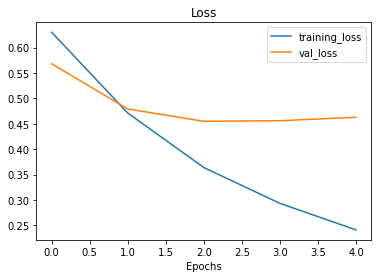

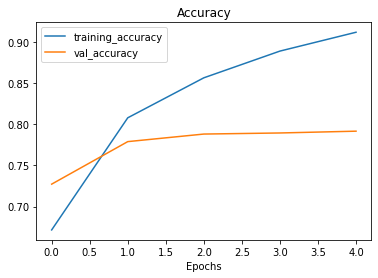

In [33]:
plot_loss_curves(model_1_history)

In [34]:
model_1_pred_probs =model_1.predict(val_sentences)

# Convert prediction probabilities to labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))


model_1_results = calculate_results(val_labels,model_1_preds)

In [35]:
model_1_results

{'accuracy': 0.7915936952714536,
 'precision': 0.8126599930816301,
 'recall': 0.7907180385288967,
 'f1': 0.7825406933727875}

In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

72/72 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.7916


[0.46276769042015076, 0.7915936708450317]

### Model 2  LSTM mode

In [37]:
# Build model with the Functional API
from tensorflow.keras import layers


model2_embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 28,
    embeddings_initializer = 'uniform',
    input_length = max_length,
    name = 'embedding_2'
)


inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.LSTM(64)(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_2 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [38]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']

)

In [39]:
history_model_2 = model_2.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        dir_name = SAVE_DIR,
        experiment_name = 'lstm_model'
    )]
)

Saving TensorBoard log files to: model_logs/lstm_model/20220912-183850
Epoch 1/5
167/167 [==============================] - 5s 9ms/step - loss: 0.2212 - accuracy: 0.9201 - val_loss: 0.5432 - val_accuracy: 0.7842
Epoch 2/5
167/167 [==============================] - 1s 7ms/step - loss: 0.1388 - accuracy: 0.9478 - val_loss: 0.6848 - val_accuracy: 0.7693
Epoch 3/5
167/167 [==============================] - 1s 6ms/step - loss: 0.1098 - accuracy: 0.9568 - val_loss: 0.7612 - val_accuracy: 0.7719
Epoch 4/5
167/167 [==============================] - 1s 7ms/step - loss: 0.0860 - accuracy: 0.9645 - val_loss: 0.7773 - val_accuracy: 0.7649
Epoch 5/5
167/167 [==============================] - 1s 7ms/step - loss: 0.0680 - accuracy: 0.9702 - val_loss: 0.9528 - val_accuracy: 0.7658


In [40]:
model_2_pred_probs =model_2.predict(val_sentences)

# Convert prediction probabilities to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))


model_2_results = calculate_results(val_labels,model_2_preds)

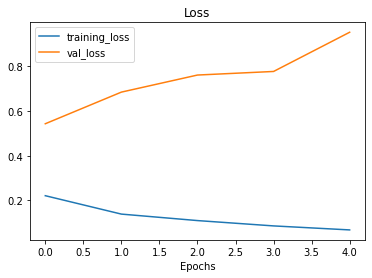

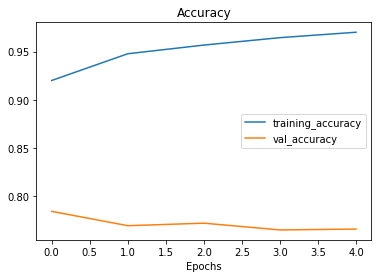

In [41]:
plot_loss_curves(history_model_2)

### Model 3 GRU

In [42]:
# Build model with the Functional API
from tensorflow.keras import layers


model3_embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 28,
    embeddings_initializer = 'uniform',
    input_length = max_length,
    name = 'embedding_3'
)

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GRU(64)(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_3 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [43]:
model_3.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [44]:
history_3  = model_3.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,'GRU')]
)

Saving TensorBoard log files to: model_logs/GRU/20220912-183902
Epoch 1/5
167/167 [==============================] - 3s 9ms/step - loss: 0.1602 - accuracy: 0.9339 - val_loss: 0.6829 - val_accuracy: 0.7636
Epoch 2/5
167/167 [==============================] - 1s 6ms/step - loss: 0.0653 - accuracy: 0.9754 - val_loss: 0.8871 - val_accuracy: 0.7456
Epoch 3/5
167/167 [==============================] - 1s 7ms/step - loss: 0.0587 - accuracy: 0.9784 - val_loss: 0.8666 - val_accuracy: 0.7601
Epoch 4/5
167/167 [==============================] - 1s 7ms/step - loss: 0.0508 - accuracy: 0.9797 - val_loss: 0.8889 - val_accuracy: 0.7544
Epoch 5/5
167/167 [==============================] - 1s 6ms/step - loss: 0.0442 - accuracy: 0.9812 - val_loss: 1.0720 - val_accuracy: 0.7588


In [45]:
model_3_pred_probs =model_3.predict(val_sentences)

# Convert prediction probabilities to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))


model_3_results = calculate_results(val_labels,model_3_preds)

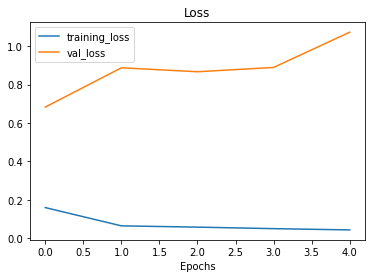

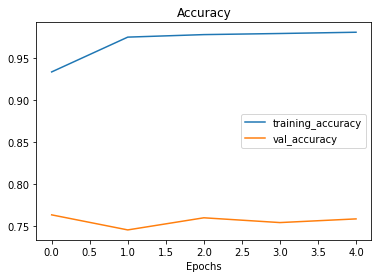

In [46]:
plot_loss_curves(history_3)

### Model 4 Bidirectonal RNN Model

In [47]:
# Build model with the Functional API
from tensorflow.keras import layers


model4_embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 28,
    embeddings_initializer = 'uniform',
    input_length = max_length,
    name = 'embedding_4'
)


inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = model4_embedding(x) # create an embedding of the numerized numbers
x = layers.Bidirectional(layers.LSTM(64))(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional_lstm") # construct the model

In [48]:
model_4.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [49]:
history_4 = model_4.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        SAVE_DIR,'bidirectional_RNN'
    )]
)

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220912-183911
Epoch 1/5
167/167 [==============================] - 5s 13ms/step - loss: 0.5473 - accuracy: 0.7153 - val_loss: 0.4672 - val_accuracy: 0.7833
Epoch 2/5
167/167 [==============================] - 1s 8ms/step - loss: 0.3197 - accuracy: 0.8683 - val_loss: 0.4663 - val_accuracy: 0.7780
Epoch 3/5
167/167 [==============================] - 1s 8ms/step - loss: 0.1958 - accuracy: 0.9263 - val_loss: 0.5815 - val_accuracy: 0.7675
Epoch 4/5
167/167 [==============================] - 1s 9ms/step - loss: 0.1358 - accuracy: 0.9542 - val_loss: 0.6378 - val_accuracy: 0.7644
Epoch 5/5
167/167 [==============================] - 1s 9ms/step - loss: 0.0949 - accuracy: 0.9704 - val_loss: 0.7217 - val_accuracy: 0.7535


In [50]:
model_4_pred_probs =model_4.predict(val_sentences)

# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))


model_4_results = calculate_results(val_labels,model_4_preds)

### Model 5 1D Convolutional Neural Network

In [51]:
tf.random.set_seed(42)

from tensorflow.keras import layers

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = model_5_embedding(x) # create an embedding of the numerized numbers

x = layers.Conv1D(filters=32,kernel_size=5,activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)


outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_5 = tf.keras.Model(inputs, outputs, name="model_5_1D_conv") # construct the model


In [52]:
model_5.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [53]:
history_5 = model_5.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(
        SAVE_DIR,'1D_cov'
    )]
)

Saving TensorBoard log files to: model_logs/1D_cov/20220912-183923
Epoch 1/5
167/167 [==============================] - 8s 7ms/step - loss: 0.5942 - accuracy: 0.6943 - val_loss: 0.4882 - val_accuracy: 0.7789
Epoch 2/5
167/167 [==============================] - 1s 5ms/step - loss: 0.3538 - accuracy: 0.8581 - val_loss: 0.4646 - val_accuracy: 0.7877
Epoch 3/5
167/167 [==============================] - 1s 6ms/step - loss: 0.1956 - accuracy: 0.9315 - val_loss: 0.5300 - val_accuracy: 0.7758
Epoch 4/5
167/167 [==============================] - 1s 6ms/step - loss: 0.1176 - accuracy: 0.9623 - val_loss: 0.6125 - val_accuracy: 0.7675
Epoch 5/5
167/167 [==============================] - 1s 6ms/step - loss: 0.0816 - accuracy: 0.9743 - val_loss: 0.6627 - val_accuracy: 0.7640


In [54]:
model_5_pred_probs =model_5.predict(val_sentences)

# Convert prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))


model_5_results = calculate_results(val_labels,model_5_preds)

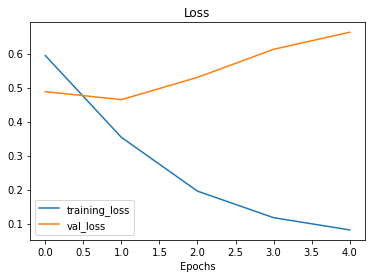

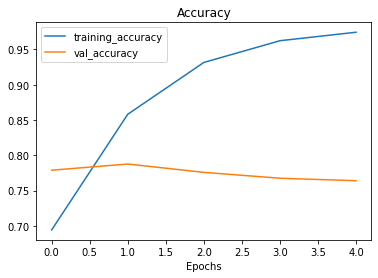

In [55]:
plot_loss_curves(history_5)

### Model_6 Pre Trained Model

In [56]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')



In [57]:
sentence_encode_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                       input_shape = [],
                                       dtype = tf.string,
                                       trainable = False,
                                       name = 'use')

In [58]:
model_6 = tf.keras.Sequential([
    sentence_encode_layer,
    layers.Dense(64,activation= 'relu'),
    layers.Dense(1,activation = 'sigmoid')
],name = 'model_6_use')

model_6.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model_6.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [59]:
model_6_history = model_6.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,'tf_hub_sentence_encoder')]
)


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220912-184002
Epoch 1/5
167/167 [==============================] - 5s 16ms/step - loss: 0.5215 - accuracy: 0.7825 - val_loss: 0.4481 - val_accuracy: 0.7995
Epoch 2/5
167/167 [==============================] - 2s 14ms/step - loss: 0.4166 - accuracy: 0.8137 - val_loss: 0.4310 - val_accuracy: 0.8065
Epoch 3/5
167/167 [==============================] - 2s 14ms/step - loss: 0.3995 - accuracy: 0.8247 - val_loss: 0.4279 - val_accuracy: 0.8052
Epoch 4/5
167/167 [==============================] - 3s 21ms/step - loss: 0.3905 - accuracy: 0.8309 - val_loss: 0.4310 - val_accuracy: 0.8065
Epoch 5/5
167/167 [==============================] - 3s 17ms/step - loss: 0.3814 - accuracy: 0.8324 - val_loss: 0.4371 - val_accuracy: 0.8117


In [60]:
model_6_pred_probs =model_6.predict(val_sentences)

# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))


model_6_results = calculate_results(val_labels,model_6_preds)

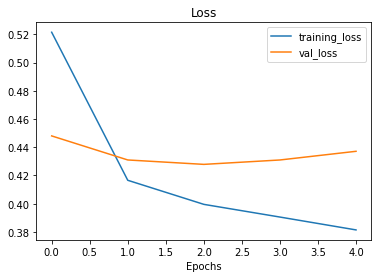

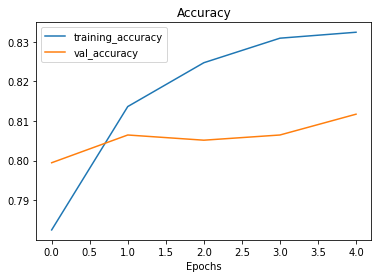

In [61]:
plot_loss_curves(model_6_history)

### Model 7 with 10% of the data

In [62]:
#Clone the model
model_7 = tf.keras.models.clone_model(model_6)

#Compile model
model_7.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Get a summary of the model 7 
model_7.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
model_7_history = model_7.fit(
    train_sentences,train_labels,
    epochs = 5,
    validation_data = (val_sentences,val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,'tf_hub_sentence_encoder_10%')]
)


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10%/20220912-184024
Epoch 1/5
167/167 [==============================] - 5s 16ms/step - loss: 0.5261 - accuracy: 0.7716 - val_loss: 0.4488 - val_accuracy: 0.8004
Epoch 2/5
167/167 [==============================] - 2s 14ms/step - loss: 0.4173 - accuracy: 0.8120 - val_loss: 0.4314 - val_accuracy: 0.8065
Epoch 3/5
167/167 [==============================] - 2s 14ms/step - loss: 0.3999 - accuracy: 0.8244 - val_loss: 0.4279 - val_accuracy: 0.8025
Epoch 4/5
167/167 [==============================] - 2s 13ms/step - loss: 0.3909 - accuracy: 0.8315 - val_loss: 0.4317 - val_accuracy: 0.8095
Epoch 5/5
167/167 [==============================] - 2s 14ms/step - loss: 0.3819 - accuracy: 0.8337 - val_loss: 0.4366 - val_accuracy: 0.8117


In [64]:
model_7_pred_probs =model_7.predict(val_sentences)

# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))


model_7_results = calculate_results(val_labels,model_7_preds)

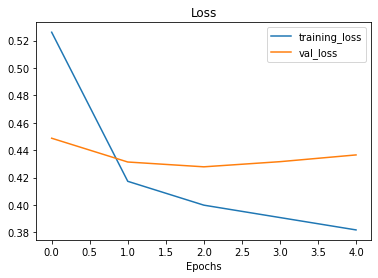

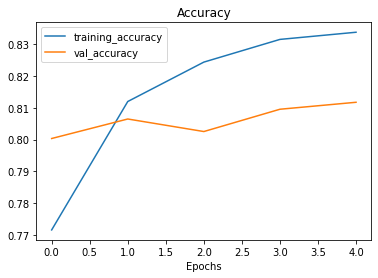

In [65]:
plot_loss_curves(model_7_history)

### Compare all the models

In [79]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.790718,0.81266,0.790718,0.782541
simple_dense,0.791594,0.81266,0.790718,0.782541
lstm,0.765762,0.81266,0.790718,0.782541
gru,0.758757,0.81266,0.790718,0.782541
bidirectional,0.753503,0.81266,0.790718,0.782541
conv1d,0.764011,0.81266,0.790718,0.782541
tf_hub_sentence_encoder,0.811734,0.81266,0.790718,0.782541
tf_hub_10_percent_data,0.811734,0.81266,0.790718,0.782541


In [78]:
# all_model_results['accuracy'] = all_model_results['accuracy']

In [80]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.790718,0.81266,0.790718,0.782541
simple_dense,0.791594,0.81266,0.790718,0.782541
lstm,0.765762,0.81266,0.790718,0.782541
gru,0.758757,0.81266,0.790718,0.782541
bidirectional,0.753503,0.81266,0.790718,0.782541
conv1d,0.764011,0.81266,0.790718,0.782541
tf_hub_sentence_encoder,0.811734,0.81266,0.790718,0.782541
tf_hub_10_percent_data,0.811734,0.81266,0.790718,0.782541


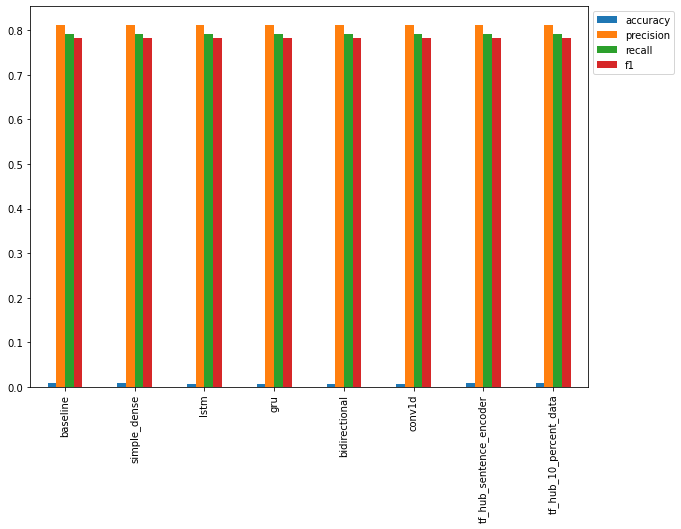

In [69]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

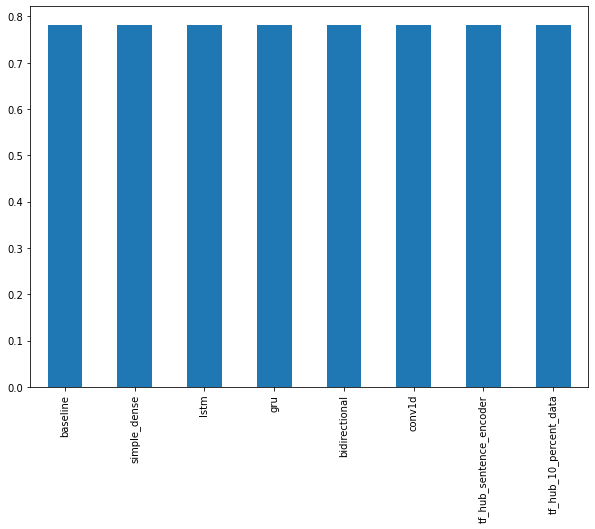

In [70]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [71]:
# # # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

# Combining our Models ( Model ensembling / stacking)

Few ways to ensemble/Combine our models : 

*   Averaging - Take the output prediction probabilities of each model for each sample, combine them and then average them.
*   Majority vote (mode) - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.
*   Model stacking - Take the outputs of each of your chosen models and use them as inputs to another model.


#### Combining model_0, Model_2 and model_6

In [72]:
# Get mean pred prob of 3 modle 

baseline_pred_probs = np.max(model_0.predict_proba(val_sentences),axis = 1)

#Combine all the model results
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs,axis=1) +tf.squeeze(model_6_pred_probs)

combined_pred = tf.round(combined_pred_probs/3)

combined_pred[:20]



<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [74]:
ensemble_results = calculate_results(val_labels,combined_pred)
ensemble_results

{'accuracy': 0.7841506129597198,
 'precision': 0.8126599930816301,
 'recall': 0.7907180385288967,
 'f1': 0.7825406933727875}

In [81]:
all_model_results.loc['ensemble_results'] = ensemble_results

In [82]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.790718,0.81266,0.790718,0.782541
simple_dense,0.791594,0.81266,0.790718,0.782541
lstm,0.765762,0.81266,0.790718,0.782541
gru,0.758757,0.81266,0.790718,0.782541
bidirectional,0.753503,0.81266,0.790718,0.782541
conv1d,0.764011,0.81266,0.790718,0.782541
tf_hub_sentence_encoder,0.811734,0.81266,0.790718,0.782541
tf_hub_10_percent_data,0.811734,0.81266,0.790718,0.782541
ensemble_results,0.784151,0.81266,0.790718,0.782541


## Saving and Loading a Trained Model

In [83]:
model_6.save('model_6.h5')

In [84]:
loaded_model_6 = tf.keras.models.load_model('model_6.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [85]:
loaded_model_6.evaluate(val_sentences,val_labels)

72/72 [==============================] - 2s 16ms/step - loss: 0.4371 - accuracy: 0.8117


[0.4371476471424103, 0.8117337822914124]

In [86]:
model_6.save('model_6_default_format')

In [87]:
loaded_model_6_default_format = tf.keras.models.load_model('model_6_default_format')

In [88]:
loaded_model_6_default_format.evaluate(val_sentences,val_labels)

72/72 [==============================] - 2s 18ms/step - loss: 0.4371 - accuracy: 0.8117


[0.4371476471424103, 0.8117337822914124]

### Finding the most wrong examples

In [89]:
val_df = pd.DataFrame({
    'text':val_sentences,
    'target':val_labels,
    'pred':model_6_preds,
    'pred_prob':tf.squeeze(model_6_pred_probs)
})

In [91]:
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.166464
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.741097
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.983356
3,@camilacabello97 Internally and externally scr...,1,0.0,0.121950
4,Radiation emergency #preparedness starts with ...,1,1.0,0.682982
...,...,...,...,...
2279,Typhoon Soudelor was captured in this incredib...,1,1.0,0.935929
2280,WA smiles after July deluge - The West Austral...,0,0.0,0.237521
2281,Earthquake and tsunami that occurred in Japan ...,1,1.0,0.952466
2282,Ancient Mayan Tablet with Hieroglyphics Honors...,0,0.0,0.126315


In [102]:
correct_prediction = val_df[val_df['target'] == val_df['pred']].sort_values('pred_prob',ascending=False)
correct_prediction[:20]

,text,target,pred,pred_prob
1369,Twelve feared killed in Pakistani air ambulanc...,1,1.0,0.992612
2200,#WorldNews Fallen powerlines on G:link tram: U...,1,1.0,0.992503
90,Dramatic Video Shows Plane Landing During Viol...,1,1.0,0.992374
1137,#reuters Twelve feared killed in Pakistani air...,1,1.0,0.991980
1238,Arson suspect linked to 30 fires caught in Nor...,1,1.0,0.991590
2185,Man killed in crash in Barrington Hills: A Hof...,1,1.0,0.991038
388,13 security personnel killed in Iraq suicide b...,1,1.0,0.991028
179,beforeitsnews : Hundreds feared dead after Lib...,1,1.0,0.990824
900,Transportation panel showing a video of a pile...,1,1.0,0.990714
1857,Landslide caused by severe rainstorm kills 3 i...,1,1.0,0.990656


In [95]:
wrong_prediction = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob',ascending=False)
wrong_prediction[:20]

,text,target,pred,pred_prob
881,@adorableappple No reported flooding po in the...,0,1.0,0.960161
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.931998
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.908987
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.894444
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.887306
769,Weapons stolen from National Guard Armory in N...,0,1.0,0.882715
759,FedEx will no longer transport bioterror patho...,0,1.0,0.880541
1620,'Dangerous' property in downtown Phoenix demol...,0,1.0,0.877650
846,Mourning notices for stabbing arson victims st...,0,1.0,0.870545
1933,One thing for sure-God has promised Israel wil...,0,1.0,0.870446


## Predicting on New Tweets (Apart from test dataset)

In [104]:
sentence1 = 'Life like an ensemble; take the best choice from others and make your own'
sentence2 = 'Twelve feared killed in Pakistani air ambulance strike'

In [115]:
pred_prob = model_6.predict([sentence1])

tf.squeeze(tf.round(pred_prob)).numpy() ,pred_prob

(0.0, array([[0.07185964]], dtype=float32))

In [121]:
def predict_on_sentence(model,sentence):
  pred_prob = model_6.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()

  print(f'Pred : {pred_label}',"(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]} \n")
  print(f'Text\n{sentence}')



In [123]:
predict_on_sentence(model_6,sentence1)

Pred : 0.0 (not real disaster) Prob: 0.07185964286327362 

Text
Life like an ensemble; take the best choice from others and make your own


### Calculate the time to predict

In [124]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [136]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.7067877280005632, 0.000309451719790089)

In [135]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.054318595999575336, 2.3782222416626678e-05)

In [132]:
model_6_time_per_pred - baseline_time_per_pred 

0.00044387234063056314

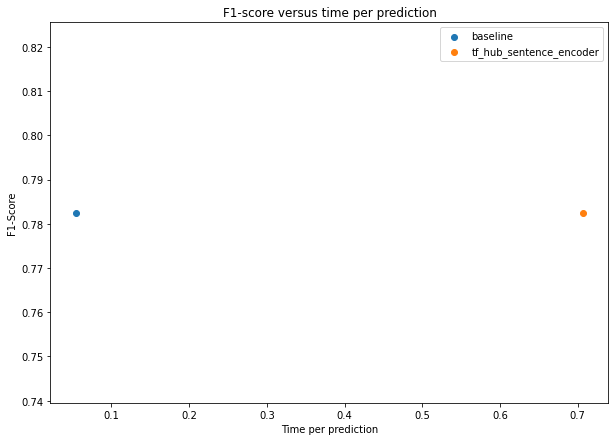

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_total_pred_time, baseline_results["f1"], label="baseline")
plt.scatter(model_6_total_pred_time, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");